In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC  
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
PassangerId = train['PassengerId']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


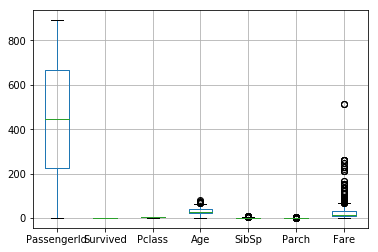

In [3]:
datasets = [train, test]
train.boxplot()

# Handling the missing **values**

In [4]:
# dealing with missing values
for dataset in datasets:
  
  Median = dataset['Age'].median()
  null_age_count = dataset["Age"].isna().sum()
  dataset['Age'][np.isnan(dataset['Age'])]= [Median]*null_age_count
  
  dataset['hasCabin'] = True
  null_cabin_count = dataset["Cabin"].isna().sum()
  dataset['hasCabin'][dataset['Cabin'].isnull()] = [False]*null_cabin_count
      
  dataset['Fare'][dataset['Fare'].isnull()] = dataset['Fare'].median()
  dataset['Embarked'][dataset['Embarked'].isnull()] = "C"
  
  dataset.drop('Cabin', axis=1, inplace=True)

In [5]:
print(test.isna().sum())
print("\nNo more missing values")
train.head()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
hasCabin       0
dtype: int64

No more missing values


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,hasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,False


In [6]:
# Let's transform this data set into integer dataset
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ""

for dataset in datasets:
  
  dataset['Social_Category'] = dataset['Name'].apply(get_title)
  dataset['Social_Category'] = dataset['Social_Category'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Social_Category'] = dataset['Social_Category'].replace('Mlle', 'Miss')
  dataset['Social_Category'] = dataset['Social_Category'].replace('Ms', 'Miss')
  dataset['Social_Category'] = dataset['Social_Category'].replace('Mme', 'Mrs')
  dataset['Social_Category'] = dataset['Social_Category'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
  dataset['Social_Category'] = dataset['Social_Category'].fillna(0)


  dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
  
  dataset.loc[ dataset['Age'] <= 18, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 40), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 65), 'Age'] = 2
  dataset.loc[ dataset['Age'] > 65, 'Age'] = 3 
  dataset['Age'] = dataset['Age'].astype(int)
    
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)
    
  dataset['hasCabin'] = dataset['hasCabin'].map({False: 0, True: 1}).astype(int)
    
  dataset['Handicap'] = dataset['SibSp'] + dataset['Parch']
  


In [7]:
train_set = train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "hasCabin", "Social_Category", "Handicap"]]
test_set = test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "hasCabin", "Social_Category", "Handicap"]]
test_set.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,Social_Category,Handicap
0,3,1,1,0,0,0,2,0,1,0
1,3,0,2,1,0,0,0,0,3,1
2,2,1,2,0,0,1,2,0,1,0
3,3,1,1,0,0,1,0,0,1,0
4,3,0,1,1,1,1,0,0,3,2


In [8]:
train_set.to_csv('train_set.csv', index=False)
test_set.to_csv('test_set.csv', index=False)


# **1-Logistic regression**

---



In [9]:
X_train, y_train = train_set.loc[:, train_set.columns != 'Survived'], train_set.loc[:, train_set.columns == 'Survived']
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
X_test = test_set
y_test = (pd.read_csv('./gender_submission.csv'))['Survived']
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [11]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[251  15]
 [  9 143]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       266
           1       0.91      0.94      0.92       152

   micro avg       0.94      0.94      0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



# 2-Naive Bayes **Classifier**


---



In [12]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [13]:
y_pred = gnb.predict(X_test)

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum(),
          100*(1-(y_test != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 418 points : 62, performance 85.17%


# 3-Support Vector **Machine**

---





## 1.   **Linear kernal**



In [14]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [15]:
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[262   4]
 [  3 149]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       266
           1       0.97      0.98      0.98       152

   micro avg       0.98      0.98      0.98       418
   macro avg       0.98      0.98      0.98       418
weighted avg       0.98      0.98      0.98       418






## **2.   Polynomial kernal**



In [16]:
svclassifier = SVC(kernel='poly', degree=8)  
svclassifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=8, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [17]:
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))

[[236  30]
 [ 32 120]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       266
           1       0.80      0.79      0.79       152

   micro avg       0.85      0.85      0.85       418
   macro avg       0.84      0.84      0.84       418
weighted avg       0.85      0.85      0.85       418




## **3.   Gaussian Kernel**



In [18]:
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))


[[247  19]
 [  7 145]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       266
           1       0.88      0.95      0.92       152

   micro avg       0.94      0.94      0.94       418
   macro avg       0.93      0.94      0.93       418
weighted avg       0.94      0.94      0.94       418



## **4.   Sigmoïd Kernel**

In [20]:
svclassifier = SVC(kernel='sigmoid')  
svclassifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))

[[203  63]
 [ 44 108]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       266
           1       0.63      0.71      0.67       152

   micro avg       0.74      0.74      0.74       418
   macro avg       0.73      0.74      0.73       418
weighted avg       0.75      0.74      0.75       418



# 4-Decision Trees

---


In [22]:
decision_clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
decision_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [23]:
y_pred = decision_clf.predict(X_test)
print('Accuracy score is: ', accuracy_score(y_test, y_pred)*100)

Accuracy score is:  82.05741626794259


In [24]:
# Random Forest Algorithm
from random import seed
from random import randrange
from csv import reader
from math import sqrt

In [25]:
# Load a CSV file
def load_csv(filename):
    #init the dataset as a list
	dataset = list()
    #open it as a readable file
	with open(filename, 'r') as file:
        #init the csv reader
		csv_reader = reader(file)
        #for every row in the dataset
		for row in csv_reader:
			if not row:
				continue
            #add that row as an element in our dataset list (2D Matrix of values)
			dataset.append(row)
    #return in-memory data matrix
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
    #iterate throw all the rows in our data matrix
	for row in dataset:
        #for the given column index, convert all values in that column to floats
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
    #store a given column 
    class_values = [row[column] for row in dataset]
    #create an unordered collection with no duplicates, only unique valeus
    unique = set(class_values)
    #init a lookup table
    lookup = dict()
    #for each element in the column
    for i, value in enumerate(unique):
        #add it to our lookup table
        lookup[value] = i
    #the lookup table stores pointers to the strings
    for row in dataset:
        row[column] = lookup[row[column]]
    #return the lookup table
    return lookup

In [26]:
# Split a dataset into k folds
# the original sample is randomly partitioned into k equal sized subsamples. 
#Of the k subsamples, a single subsample is retained as the validation data 
#for testing the model, and the remaining k − 1 subsamples are used as training data. 
#The cross-validation process is then repeated k times (the folds),
#with each of the k subsamples used exactly once as the validation data.
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    #init 2 empty lists for storing split dataubsets
	left, right = list(), list()
    #for every row
	for row in dataset:
        #if the value at that row is less than the given value
		if row[index] < value:
            #add it to list 1
			left.append(row)
		else:
            #else add it list 2 
			right.append(row)
    #return both lists
	return left, right
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    #how many correct predictions?
	correct = 0
    #for each actual label
	for i in range(len(actual)):
        #if actual matches predicted label
		if actual[i] == predicted[i]:
            #add 1 to the correct iterator
			correct += 1
    #return percentage of predictions that were correct
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    #folds are the subsamples used to train and validate model
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
    #for each subsample
	for fold in folds:
        #create a copy of the data
		train_set = list(folds)
        #remove the given subsample
		train_set.remove(fold)
		train_set = sum(train_set, [])
        #init a test set
		test_set = list()
        #add each row in a given subsample to the test set
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
        #get predicted labls
		predicted = algorithm(train_set, test_set, *args)
        #get actual labels
		actual = [row[-1] for row in fold]
        #compare accuracy
		accuracy = accuracy_metric(actual, predicted)
        #add it to scores list, for each fold
		scores.append(accuracy)
    #return all accuracy scores
	return scores
 
 
# Calculate the Gini index for a split dataset
## this is the name of the cost function used to evaluate splits in the dataset.
# this is a measure of how often a randomly chosen element from the set 
#would be incorrectly labeled if it was randomly labeled according to the distribution
#of labels in the subset. Can be computed by summing the probability
#of an item with label i being chosen times the probability 
#of a mistake in categorizing that item. 
#It reaches its minimum (zero) when all cases in the node 
#fall into a single target category.
#A split in the dataset involves one input attribute and one value for that attribute. 
#It can be used to divide training patterns into two groups of rows.
#A Gini score gives an idea of how good a split is by how mixed the classes 
#are in the two groups created by the split. A perfect separation results in 
#a Gini score of 0, whereas the worst case split that results in 50/50 classes 
#in each group results in a Gini score of 1.0 (for a 2 class problem).
#We first need to calculate the proportion of classes in each group.
def gini_index(groups, class_values):
	gini = 0.0
    #for each class
	for class_value in class_values:
        #a random subset of that class
		for group in groups:
			size = len(group)
			if size == 0:
				continue
            #average of all class values
			proportion = [row[-1] for row in group].count(class_value) / float(size)
            #  sum all (p * 1-p) values, this is gini index
			gini += (proportion * (1.0 - proportion))
	return gini
 
# Select the best split point for a dataset
#This is an exhaustive and greedy algorithm
def get_split(dataset, n_features):
    ##Given a dataset, we must check every value on each attribute as a candidate split, 
    #evaluate the cost of the split and find the best possible split we could make.
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
            ##When selecting the best split and using it as a new node for the tree 
            #we will store the index of the chosen attribute, the value of that attribute 
            #by which to split and the two groups of data split by the chosen split point.
            ##Each group of data is its own small dataset of just those rows assigned to the 
            #left or right group by the splitting process. You can imagine how we might split 
            #each group again, recursively as we build out our decision tree.
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    ##Once the best split is found, we can use it as a node in our decision tree.
    ##We will use a dictionary to represent a node in the decision tree as 
    #we can store data by name. 
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value

def to_terminal(group):
    #select a class value for a group of rows. 
	outcomes = [row[-1] for row in group]
    #returns the most common output value in a list of rows.
	return max(set(outcomes), key=outcomes.count)
 
#Create child splits for a node or make terminal
#Building a decision tree involves calling the above developed get_split() function over 
#and over again on the groups created for each node.
#New nodes added to an existing node are called child nodes. 
#A node may have zero children (a terminal node), one child (one side makes a prediction directly) 
#or two child nodes. We will refer to the child nodes as left and right in the dictionary representation 
#of a given node.
#Once a node is created, we can create child nodes recursively on each group of data from 
#the split by calling the same function again.
def split(node, max_depth, min_size, n_features, depth):
    #Firstly, the two groups of data split by the node are extracted for use and 
    #deleted from the node. As we work on these groups the node no longer requires access to these data.
	left, right = node['groups']
	del(node['groups'])
    
    #Next, we check if either left or right group of rows is empty and if so we create 
    #a terminal node using what records we do have.
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
    #We then check if we have reached our maximum depth and if so we create a terminal node.
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
    #We then process the left child, creating a terminal node if the group of rows is too small, 
    #otherwise creating and adding the left node in a depth first fashion until the bottom of 
    #the tree is reached on this branch.
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
    #The right side is then processed in the same manner, 
    #as we rise back up the constructed tree to the root.
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)
 
#Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    #Building the tree involves creating the root node and 
	root = get_split(train, n_features)
    #calling the split() function that then calls itself recursively to build out the whole tree.
	split(root, max_depth, min_size, n_features, 1)
	return root
 
# Make a prediction with a decision tree
def predict(node, row):
    #Making predictions with a decision tree involves navigating the 
    #tree with the specifically provided row of data.
    #Again, we can implement this using a recursive function, where the same prediction routine is 
    #called again with the left or the right child nodes, depending on how the split affects the provided data.
    #We must check if a child node is either a terminal value to be returned as the prediction
    #, or if it is a dictionary node containing another level of the tree to be considered.
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
 
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

In [27]:
# Make a prediction with a list of bagged trees
#responsible for making a prediction with each decision tree and 
#combining the predictions into a single return value. 
#This is achieved by selecting the most common prediction 
#from the list of predictions made by the bagged trees.
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)
 
# Random Forest Algorithm
#esponsible for creating the samples of the training dataset, training a decision tree on each,
#then making predictions on the test dataset using the list of bagged trees.
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)
 
# Test the random forest algorithm
seed(1)
# load and prepare data
filename = 'train_set.csv'
dataset = load_csv(filename)
dataset = dataset[1:]
# convert string attributes to integers
for i in range(0, len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5, 10]:
	#scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
	print('Trees: %d' % n_trees)
	#print('Scores: %s' % scores)
	#print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Trees: 5
Trees: 10


In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
y_pred=clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))


[0.11855497 0.29515633 0.02455758 0.0330362  0.02148317 0.04873939
 0.01829992 0.07157784 0.29135029 0.07724433]
Accuracy: 0.9449760765550239


# 5- K-Nearest Neighbors

---


In [29]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

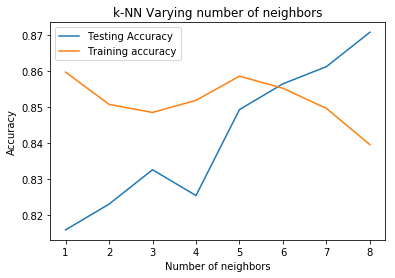

In [30]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [31]:
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[239  27]
 [ 27 125]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       266
           1       0.82      0.82      0.82       152

   micro avg       0.87      0.87      0.87       418
   macro avg       0.86      0.86      0.86       418
weighted avg       0.87      0.87      0.87       418



In [32]:
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
knn_cv.best_score_


0.8282828282828283

In [34]:
knn_cv.best_params_


{'n_neighbors': 20}

In [35]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6, 3), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[254  12]
 [ 12 140]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       266
           1       0.92      0.92      0.92       152

   micro avg       0.94      0.94      0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



In [37]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
len(X_train)


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(891, 10))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100)

In [ ]:
results = model.evaluate(X_test, y_test)
results
history_dict = history.history
history_dict.keys()